In [ ]:
random_seed = 1
import random
random.seed(random_seed)

import numpy as np
# set the random seed to make the experiment reproducible
np.random.seed(random_seed)

import tensorflow
# set seed
tensorflow.random.set_seed(random_seed)

In [78]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
from keras.utils import np_utils

# imblean provides tools for us to deal with imbalanced class sizes
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import ADASYN

import sklearn
assert sklearn.__version__ >= "0.20"

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [33]:
X_train_df = pd.read_excel('data/model_inputs/x_train_3perc.xlsx', index_col=0)
X_test_df = pd.read_excel('data/model_inputs/x_test_3perc.xlsx', index_col=0)
y_train_df = pd.read_excel('data/model_inputs/y_train_3perc.xlsx', index_col=0)
y_test_df = pd.read_excel('data/model_inputs/y_test_3perc.xlsx', index_col=0)

In [34]:
pd.DataFrame(y_train_df.reset_index()).groupby('decision').count()

,index
decision,
-1,147
0,1264
1,100


### Oversampling

In [35]:
def smote(X_train, y_train):
    sm = SMOTE(sampling_strategy='not majority')
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    return X_train_oversampled, y_train_oversampled

def random_oversampler(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='not majority')
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    return X_over, y_over

def adasyn(X_train, y_train):
    ada = ADASYN(sampling_strategy = 'not majority')
    X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [36]:
sm = smote(X_train_df, y_train_df)
sm[1].value_counts()

decision
-1          1264
 0          1264
 1          1264
dtype: int64

In [37]:
random_oversampling = random_oversampler(X_train_df, y_train_df)
random_oversampling[1].value_counts()

decision
-1          1264
 0          1264
 1          1264
dtype: int64

In [38]:
ada = adasyn(X_train_df, y_train_df)
ada[1].value_counts()

decision
 0          1264
 1          1258
-1          1235
dtype: int64

### Shuffle + Numpy Array

In [39]:
def shuffle_numpy_encode(X_train, X_test, y_train, y_test):
    # shuffle the dataset! 
    train_data = X_train.copy(deep=True)
    train_data['decision'] = y_train['decision']

    train_data = train_data.sample(frac=1)

    X_train = train_data.drop(['decision'], axis=1)
    y_train = pd.DataFrame(train_data['decision'])
    
    # convert to numpy arrays
    X_train = np.array(X_train).astype(dtype='float64')
    X_test = np.array(X_test).astype(dtype='float64')

    y_train = np.array(y_train['decision'])
    y_test = np.array(y_test['decision'])

    # one hot encode
    # y_train = np_utils.to_categorical(y_train, num_classes=3)
    # y_test = np_utils.to_categorical(y_test, num_classes=3)

    y_train = np.array(list(map(lambda x: 2 if x==-1 else x, y_train))).astype(dtype='uint8')
    y_test = np.array(list(map(lambda x: 2 if x==-1 else x, y_test))).astype(dtype='uint8')


    return X_train, X_test, y_train, y_test

In [40]:
def plot_curve(hist):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  epochs = hist.epoch
  f, ax = plt.subplots(ncols=2, figsize=(20,8))
  ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
  ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[1].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
  ax[1].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

In [41]:
from tabnanny import verbose


def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(input_shape=(X_train_df.shape[1],), units=300, activation='relu'))
  model.add(tf.keras.layers.Dense(units=100, activation='relu'))
    # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))    
                           
  # # Construct the layers into a model that TensorFlow can execute.  
  # # Notice that the loss function for multi-class classification
  # # is different than the loss function for binary classification.  
  # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
  #               loss="sparse_categorical_crossentropy", 
  #               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model    


def train_model(model, train_features, train_label, epochs,
                validation_data, batch_size=None):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_data=validation_data, verbose=0)
  
  return history   

### Train Model

In [42]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.1

# Establish the model's topography.
my_model = create_model(learning_rate)

In [43]:
results = pd.DataFrame(columns=['loss', 'accuracy'])

SMOTE Results

In [44]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(X_train_df, X_test_df, y_train_df, y_test_df)

In [45]:
X_valid = X_train[0:400]
X_train = X_train[400:]

y_valid = y_train[0:400]
y_train = y_train[400:]

In [46]:
sm = smote(X_train, y_train)
X_train = sm[0]
y_train = sm[1]

6/6 [==============================] - 0s 7ms/step - loss: 3.7435 - accuracy: 0.5000


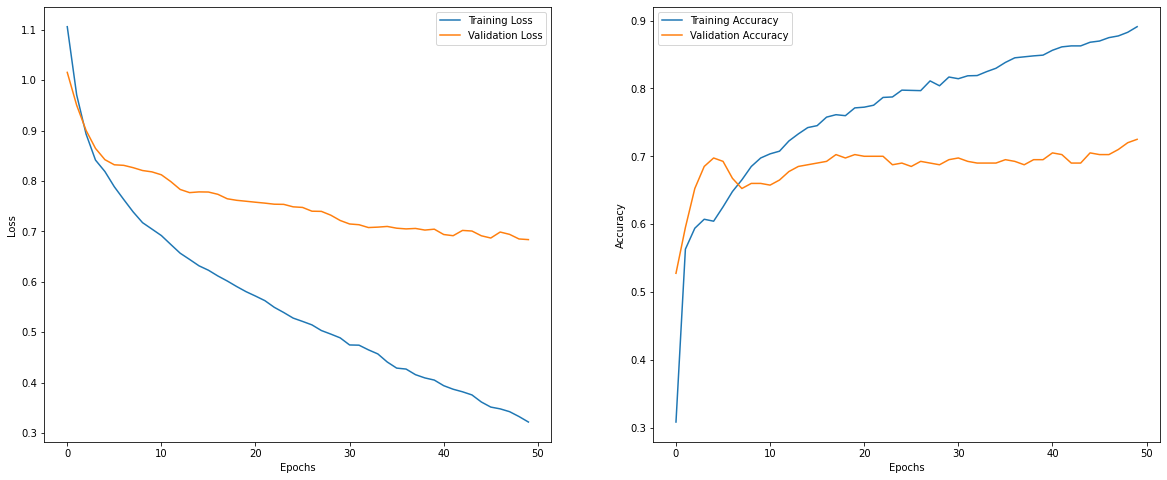

In [47]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, (X_valid, y_valid), batch_size)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# # Evaluate on Test & Save results
results.loc['smote'] = list(my_model.evaluate(X_test, y_test))

In [48]:
results

,loss,accuracy
smote,3.743491,0.5


In [49]:
predict_x=my_model.predict(X_test) 
predictions=np.argmax(predict_x,axis=1)

In [50]:
# check predictions
set(predictions)

{0, 2}

In [51]:
#confusion matrix
sklearn.metrics.multilabel_confusion_matrix(
    np.array(y_test_df['decision']),
    predictions,
    labels=[0,1,2]
    # num_classes=3,
    # weights=None,
    # dtype=tf.dtypes.int32,
    # name=None
)

array([[[  3,  79],
        [  5,  81]],

       [[125,   0],
        [ 43,   0]],

       [[160,   8],
        [  0,   0]]])

In [52]:
sklearn.metrics.f1_score(y_test_df['decision'],predictions, average='weighted')

0.3371080139372823

Random Oversampling Results

In [53]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(random_oversampling[0], X_test_df, random_oversampling[1], y_test_df)

In [54]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# Evaluate on Test & Save results
results.loc['random_oversampling'] = list(my_model.evaluate(X_test, y_test))

TypeError: Expected int32 passed to parameter 'size' of op 'Slice', got [3791.9] of type 'list' instead. Error: Expected int32, got 3791.9 of type 'float' instead.

ADASYN

In [ ]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(ada[0], X_test_df, ada[1], y_test_df)

In [ ]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# Evaluate on Test & Save results
results.loc['adasyn'] = list(my_model.evaluate(X_test, y_test))

### Results

In [ ]:
# # 3 percent
# results['f1'] = 2 * (results['precision'] * results['recall']) / (results['precision'] + results['recall'])
# results 

In [ ]:
# # 5 percent
# results['f1'] = 2 * (results['precision'] * results['recall']) / (results['precision'] + results['recall'])
# results 

### Tuning

In [79]:
#optimisation
from bayes_opt import BayesianOptimization

# model building
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Embedding, SimpleRNN , concatenate, Lambda
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics
from keras.losses import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score


def rnn_tuner2(C, batch_size, neurons1, neurons2, neurons3, activation, optimizer, dropout, dropout_rate, learning_rate, epochs, layers1, layers2):

    C = round(C, 3)
    optimizerL = ['SGD', 'Adam', 'RMSprop']
    optimizerD= {'Adam':tf.keras.optimizers.Adam(learning_rate=learning_rate), 'SGD':tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  'RMSprop':tf.keras.optimizers.RMSprop(learning_rate=learning_rate)}
    activationL = ['relu']
    neurons1 = round(neurons1)
    neurons2 = round(neurons2)
    neurons3 = round(neurons3)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)

    def create_model():
      tuned_model = Sequential()
      tuned_model.add(Dense(units=neurons1, input_shape = (X_train_df.shape[1],),kernel_regularizer=tf.keras.regularizers.l2(C))) #input_shape = (batch_size (1st dimension -> num_rows --> excluded), input_size (2nd dimension -> cols),input_dim (2-1))

      for i in range(layers1): #varying first set of hidden layers
          tuned_model.add(Dense(neurons2, activation=activation,kernel_regularizer=tf.keras.regularizers.l2(C)))

    #   if dropout > 0.5:
    #       tuned_model.add(Dropout(dropout_rate, seed=42))

      for i in range(layers2): #varying second set of hidden layers
          tuned_model.add(Dense(neurons3, activation=activation,kernel_regularizer=tf.keras.regularizers.l2(C)))

      tuned_model.add(Dense(3, activation='softmax')) #output layer

      tuned_model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
     # tuned_model = tuned_model.fit(X_train_smenn, y_train_smenn, epochs=20)
     # tuned_model.summary()
      return tuned_model

    es = EarlyStopping(monitor="loss", patience=3)
    mc = ModelCheckpoint('Best_tuned_NN.h5', monitor='val_loss',mode='min',verbose=2, save_best_only=True)

    tune_rnn = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0) 
    score = cross_val_score(tune_rnn, X_train, y_train, fit_params={'callbacks':[es]}, error_score='raise', scoring=make_scorer(f1_score, average='weighted', labels=[0,1,2])).mean() #5 fold cross validation default
    return score


In [80]:
params_rnn2 ={
    'neurons1': (100, 500),
    'neurons2': (100, 500),
    'neurons3': (100, 500),
    'C': (0,1),
    'activation':(0,0),
    'optimizer':(0,2),
    'learning_rate':(0.001, 0.01),
    'batch_size':(100, 500),
    'epochs':(20, 50),
    'layers1':(1,3),
    'layers2':(1,3),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}

In [81]:
# Run Bayesian Optimization
rnn_bo2 = BayesianOptimization(rnn_tuner2, params_rnn2, random_state=42)
rnn_bo2.maximize(init_points=25, n_iter=4)

|   iter    |  target   |     C     | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... | neurons1  | neurons2  | neurons3  | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.1578    | 0.3745    | 0.0       | 392.8     | 0.5987    | 0.04681   | 24.68     | 1.116     | 2.732     | 0.00641   | 383.2     | 108.2     | 488.0     | 1.665     |
| 2         | 0.1657    | 0.2123    | 0.0       | 173.4     | 0.3042    | 0.1574    | 32.96     | 1.582     | 2.224     | 0.002255  | 216.9     | 246.5     | 282.4     | 1.57      |
| 3         | 0.1686    | 0.1997    | 0.0       | 337.0     | 0.04645   | 0.1823    | 25.12     | 1.13      | 2.898     | 0.009691  | 423.4     | 221.8     | 139.1     | 1.368     |
| 4         | 0.1636    | 0.4402    | 0.0       | 298.1     | 0.03439   | 0.2728    | 27.7

In [82]:
best_params = rnn_bo2.max["params"]
best_params

{'C': 0.005061583846218687,
 'activation': 0.0,
 'batch_size': 319.49351574663444,
 'dropout': 0.6918951976926933,
 'dropout_rate': 0.19558837785078015,
 'epochs': 26.728079283816793,
 'layers1': 2.4243584426950715,
 'layers2': 1.4744981749936001,
 'learning_rate': 0.003928597283433409,
 'neurons1': 398.59656204720966,
 'neurons2': 359.85315961888585,
 'neurons3': 439.6893641976712,
 'optimizer': 1.3152257846006867}

In [83]:
optimizerL = ['Adam', 'SGD', 'RMSprop']
optimizerD= {'Adam':tf.keras.optimizers.Adam(learning_rate=round(best_params['learning_rate'],3)), 'SGD':tf.keras.optimizers.SGD(learning_rate=round(best_params['learning_rate'],3)),
              'RMSprop':tf.keras.optimizers.RMSprop(learning_rate=round(best_params['learning_rate'],3))}

In [84]:
tuned_model2 = Sequential()
tuned_model2.add(Dense(units=round(best_params['neurons1']), input_shape=(X_train_df.shape[1],),kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'],3)))) 

for i in range(round(best_params['layers1'])): #varying first set of hidden layers
    tuned_model2.add(Dense(round(best_params['neurons2']), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'], 3))))

# if round(best_params['dropout']) > 0.5:
#     tuned_model2.add(Dropout(round(best_params['dropout_rate'],1), seed=42))

for i in range(round(best_params['layers2'])): #varying second set of hidden layers
    tuned_model2.add(Dense(round(best_params['neurons3']), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'], 3))))

tuned_model2.add(Dense(3, activation='softmax')) #output layer

tuned_model2.compile(loss="sparse_categorical_crossentropy", optimizer = optimizerD[optimizerL[round(best_params['optimizer'])]], metrics=['accuracy'])
history = tuned_model2.fit(X_train, y_train, epochs=400, validation_data=(X_valid, y_valid))
tuned_model2.summary()

Epoch 1/400
119/119 [==============================] - 1s 6ms/step - loss: 6.7934 - accuracy: 0.5140 - val_loss: 6.7932 - val_accuracy: 0.4625
Epoch 2/400
119/119 [==============================] - 0s 4ms/step - loss: 6.6657 - accuracy: 0.5870 - val_loss: 6.7049 - val_accuracy: 0.5175
Epoch 3/400
119/119 [==============================] - 0s 4ms/step - loss: 6.5617 - accuracy: 0.5978 - val_loss: 6.6178 - val_accuracy: 0.5650
Epoch 4/400
119/119 [==============================] - 0s 4ms/step - loss: 6.4743 - accuracy: 0.6031 - val_loss: 6.5368 - val_accuracy: 0.5950
Epoch 5/400
119/119 [==============================] - 0s 4ms/step - loss: 6.3980 - accuracy: 0.6105 - val_loss: 6.4526 - val_accuracy: 0.6250
Epoch 6/400
119/119 [==============================] - 0s 4ms/step - loss: 6.3283 - accuracy: 0.6181 - val_loss: 6.3755 - val_accuracy: 0.6550
Epoch 7/400
119/119 [==============================] - 0s 4ms/step - loss: 6.2630 - accuracy: 0.6268 - val_loss: 6.3092 - val_accuracy: 0.6650

6/6 [==============================] - 0s 2ms/step - loss: 2.9812 - accuracy: 0.5000


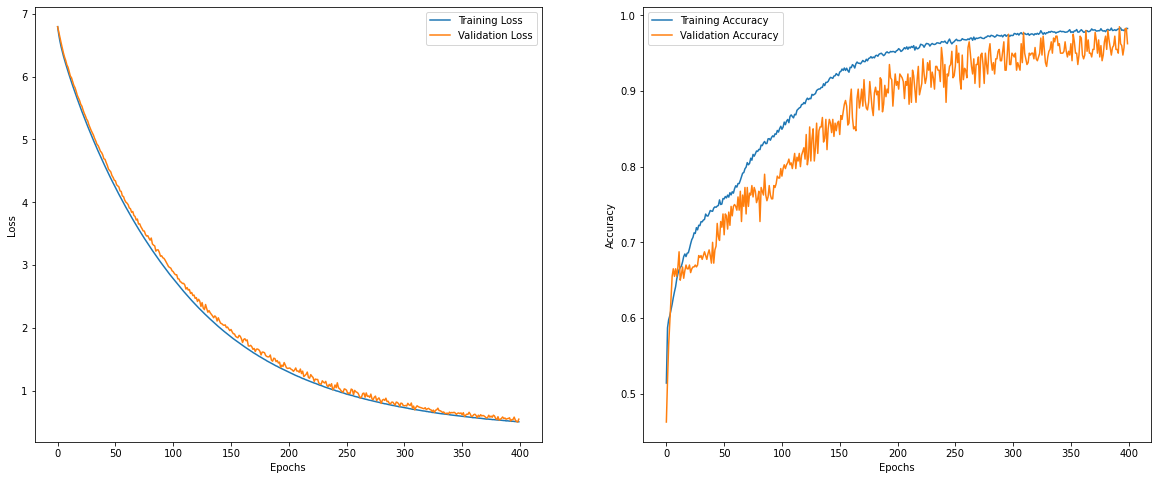

In [85]:
# Plot a graph of the metric vs. epochs.
plot_curve(history)
# # Evaluate on Test & Save results
results.loc['smote'] = list(tuned_model2.evaluate(X_test, y_test))

In [88]:
predict_x=tuned_model2.predict(X_test) 
predictions=np.argmax(predict_x,axis=1)
sklearn.metrics.f1_score(y_test,predictions, average='weighted')

0.4669090713208361

## Business Metrics

In [ ]:
import yfinance as yf

In [ ]:
whole_df_x = np.vstack((X_train_df, X_test_df))
whole_df_x.shape

In [ ]:
predict_x=tuned_model2.predict(whole_df_x) 
predictions=np.argmax(predict_x,axis=1)

In [ ]:
df_pred = pd.DataFrame({'pred':predictions}, index=target_1perc.index)
df_pred =df_pred.replace({2:-1})

df_prices = data = yf.download("^GSPC", start="2016-01-04", end="2022-09-02")[['Adj Close']]

pred_ls = []
prev = 0
for i in range(len(df_pred)):
    if df_pred.iloc[i]['pred'] == 0:
        pred_ls.append(prev)
    else:
        prev = df_pred.iloc[i]['pred']
        pred_ls.append(prev)

df_diff = np.log(df_prices /df_prices.shift(1))
df_diff['pred'] = df_pred['pred']
df_diff['pred_new'] = pred_ls
df_diff['benchmark'] = 1
df_diff["Strategy_Returns"] = df_diff["Adj Close"] * df_diff["pred_new"].shift(1)
df_diff["Benchmark_Returns"] = df_diff["Adj Close"] * df_diff["benchmark"].shift(1)

# Group by year
df_diff = df_diff.reset_index()
df_diff['year'] = df_diff['Date'].apply(lambda x: x.year)
matrix = df_diff.groupby('year').mean()
matrix['Strategy_Returns'] = np.exp(matrix['Strategy_Returns']*252)-1
matrix['Benchmark_Returns'] = np.exp(matrix['Benchmark_Returns']*252)-1

# Annual Mean Returns or Expected returns
# expected_stock_annual_return = np.exp(df_diff['Benchmark_Returns'].mean() * 252) - 1 
# expected_strategy_annual_return = np.exp(df_diff['Strategy_Returns'].mean() * 252) - 1 
#expected_target_annual_return = np.exp(df_diff['Target_Returns'].mean() * 252) - 1 
#print(f'Expected Annual Returns: Strategy: {round(expected_strategy_annual_return*100, 2)}%  |  Stock: {round(expected_stock_annual_return*100, 2)}%')

In [ ]:
matrix